This script generates the plots to compare SCITE-RNA, DENDRO and SClineager on simulated datasets with a variable number of ground truth clones. Additionally, it plots a comparison of the runtimes.

In [2]:
import numpy as np
import dendropy
from dendropy.calculate import treecompare
import warnings
import matplotlib.pyplot as plt

import json
import os
from matplotlib.patches import Patch

import matplotlib.ticker as mticker
from matplotlib.font_manager import FontProperties
from sklearn.metrics import adjusted_rand_score
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src_python.cell_tree import CellTree
from src_python.utils import load_config_and_set_random_seed, path_len_dist

In [3]:
path = r"D:\PhD\SCITERNA\simulated_data" #../data/simulated_data"
path_consensus = "../data/results"

n_cells = [50]
n_mut = [500]
n_tests = 100
clones = ["", "5", "10", "20"]

n_round = 1

config = load_config_and_set_random_seed()

use_summary_statistics = True # Uses the summary files saved in the data_summary/ directory. If raw output files were generated, set to False

models = [
    "SCITE-RNA",
    "SCITE-RNA-clustered",
    "SCITE-RNA-consensus",
    "SClineager",
    "DENDRO",
    "PhylinSic"
]

# Initialize all metrics as empty dictionaries
genotype_differences = {}
path_len_differences = {}
rf_differences = {}
quartet_differences = {}
adjusted_rand_index = {}

# List of metrics
metrics = [genotype_differences, path_len_differences, rf_differences, quartet_differences,adjusted_rand_index]

for metric in metrics:
    for model in models:
        metric[model] = {}

In [ ]:
def to_newick(ct, node):
    if ct.isleaf(node):
        return f"{node}"
    children = ct.children(node)
    return "(" + ",".join(to_newick(ct, child) for child in children) + f"){node}"

In [ ]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):

        path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        rf_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}

        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            rf_distances = []

            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")
                genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{n_round}r{t}.txt")
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
                genotype_gt = np.loadtxt(genotype_path, dtype=str)

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{n_round}r{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_predicted = vectorized_map(genotype_pred)
                genotype_gt = vectorized_map(genotype_gt)
                unique_genotypes = np.unique(genotype_gt, axis=0)

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(difference)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_sciterna, ct_sciterna.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

            path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = path_len_distances
            genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = vaf_differences
            rf_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = rf_distances

            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

In [ ]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        path_len_differences["SCITE-RNA-consensus"][f"{n_c}_{n_m}"] = {}
        rf_differences["SCITE-RNA-consensus"][f"{n_c}_{n_m}"] = {}

        for clone in clones:
            path_len_distances = []
            rf_distances = []

            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")
                base_path_consensus = os.path.join(path_consensus, f"{n_c}c{n_m}m{clone}")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path_consensus,  "sciterna_consensus_parent_vec", f"sciterna_parent_vec_{n_round}r{t}.txt"), dtype=int)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_sciterna, ct_sciterna.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

            path_len_differences["SCITE-RNA-consensus"][f"{n_c}_{n_m}"][clone] = path_len_distances
            rf_differences["SCITE-RNA-consensus"][f"{n_c}_{n_m}"][clone] = rf_distances
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

In [ ]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        rf_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            adjusted_rand_scores = []
            rf_distances = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "sciterna", "sciterna_clones", f"sciterna_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue
                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec_clustering", f"sciterna_parent_vec_clustering_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_sciterna, ct_sciterna.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))


            genotype_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = vaf_differences
            path_len_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = path_len_distances
            adjusted_rand_index["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            rf_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = rf_distances
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

In [ ]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["PhylinSic"][f"{n_c}_{n_m}"] = {}
        path_len_differences["PhylinSic"][f"{n_c}_{n_m}"] = {}
        rf_differences["PhylinSic"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            rf_distances = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T
                genotype_predicted = np.loadtxt(os.path.join(base_path, "phylinsic", "phylinsic_genotype", f"phylinsic_genotype_{t}.txt"), dtype=str)[1:]

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                phylinsic_parent_vec = np.loadtxt(os.path.join(base_path, "phylinsic", "phylinsic_parent_vec", f"phylinsic_parent_vec_{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)
                genotype_predicted = vectorized_map(genotype_predicted)

                if genotype_predicted.shape != genotype_gt.shape:
                    print("Cells or mutations were filtered out")
                    continue

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_phylinsic = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_phylinsic.use_parent_vec(phylinsic_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_phylinsic))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_phylinsic, ct_phylinsic.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

            genotype_differences["PhylinSic"][f"{n_c}_{n_m}"][clone] = vaf_differences
            path_len_differences["PhylinSic"][f"{n_c}_{n_m}"][clone] = path_len_distances
            rf_differences["PhylinSic"][f"{n_c}_{n_m}"][clone] = rf_distances
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

In [ ]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["SClineager"][f"{n_c}_{n_m}"] = {}
        rf_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            adjusted_rand_scores = []
            rf_distances = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T
                vaf_predicted = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_vaf", f"sclineager_vaf_{t}.txt"), dtype=float).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "sclineager", "sclineager_clones", f"sclineager_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                sclineager_selected = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_selected", f"sclineager_selected_{t}.txt"), dtype=int).astype(bool)

                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sclineager_parent_vec = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_parent_vec", f"sclineager_parent_vec_{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                genotype_predicted = np.round(vaf_predicted * 2) / 2
                if genotype_predicted.shape != genotype_gt.shape:
                    print(f"Cells or mutations were filtered out. {np.sum(sclineager_selected == 0)} mutations filtered out.")
                    genotype_gt = genotype_gt[sclineager_selected]

                    if genotype_gt.shape != genotype_predicted.shape:
                        print("Cells filtered out. Continue.")
                        continue

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_sclineager = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sclineager.use_parent_vec(sclineager_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sclineager))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_sclineager, ct_sclineager.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

            genotype_differences["SClineager"][f"{n_c}_{n_m}"][clone] = vaf_differences
            path_len_differences["SClineager"][f"{n_c}_{n_m}"][clone] = path_len_distances
            adjusted_rand_index["SClineager"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            rf_differences["SClineager"][f"{n_c}_{n_m}"][clone] = rf_distances
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")
            print(np.mean(rf_distances), " mean Robinson-Foulds distance")

In [ ]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        path_len_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["DENDRO"][f"{n_c}_{n_m}"] = {}
        rf_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            adjusted_rand_scores = []
            rf_distances = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "dendro", "dendro_clones", f"dendro_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue
                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)

                dendro_parent_vec = np.loadtxt(os.path.join(base_path, "dendro", "dendro_parent_vec", f"dendro_parent_vec_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_dendro = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_dendro.use_parent_vec(dendro_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_dendro))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_dendro, ct_dendro.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))


            genotype_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = vaf_differences
            path_len_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = path_len_distances
            adjusted_rand_index["DENDRO"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            rf_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = rf_distances
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")
            print(np.mean(rf_distances), " mean Robinson-Foulds distance")

In [4]:
# if not use_summary_statistics:
#     os.makedirs("../data_summary/simulated_data/", exist_ok=True)
#
#     with open("../data_summary/simulated_data/genotype_differences.json", "w") as f:
#         json.dump(genotype_differences, f)
#     with open("../data_summary/simulated_data/path_len_differences.json", "w") as f:
#         json.dump(path_len_differences, f)
#     with open("../data_summary/simulated_data/rf_differences.json", "w") as f:
#         json.dump(rf_differences, f)
#     with open("../data_summary/simulated_data/adjusted_rand_index.json", "w") as f:
#         json.dump(adjusted_rand_index, f)

if use_summary_statistics:
    with open("../data_summary/simulated_data/genotype_differences.json", "r") as f:
        genotype_differences = json.load(f)
    with open("../data_summary/simulated_data/path_len_differences.json", "r") as f:
        path_len_differences = json.load(f)
    with open("../data_summary/simulated_data/rf_differences.json", "r") as f:
        rf_differences = json.load(f)
    with open("../data_summary/simulated_data/adjusted_rand_index.json", "r") as f:
        adjusted_rand_index = json.load(f)
    with open("../data_summary/simulated_data/runtimes.json", "r") as f:
        runtime_data = json.load(f)

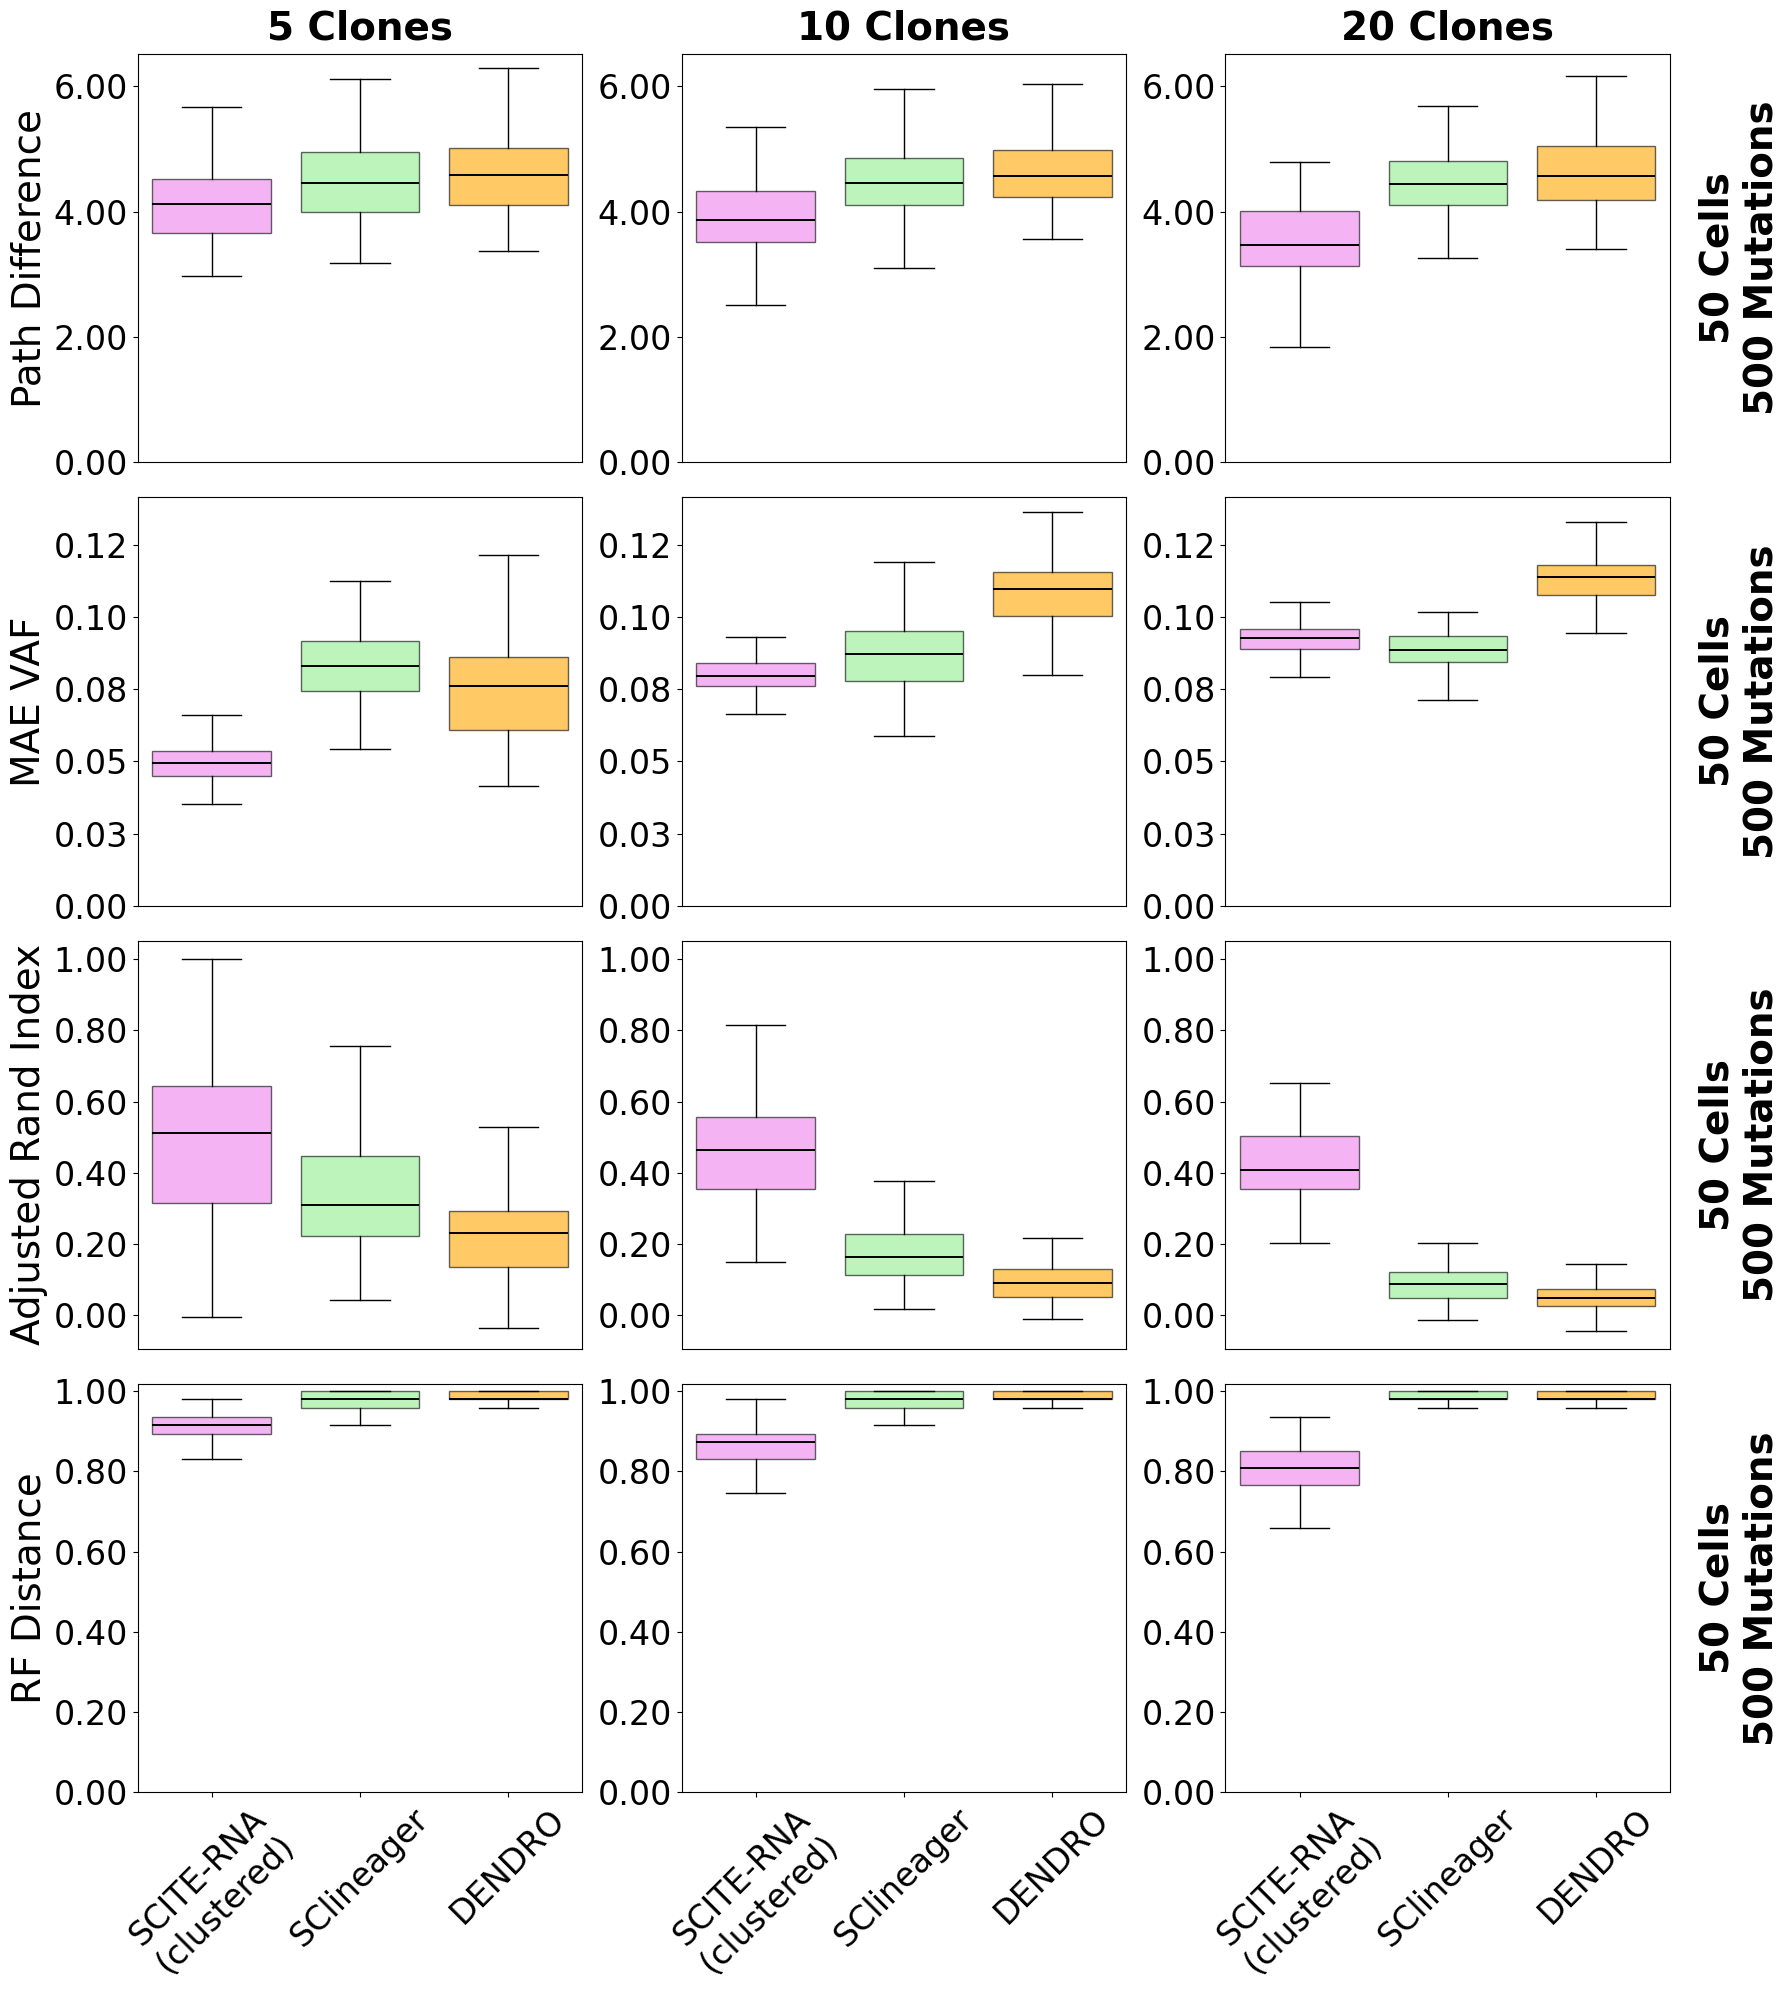

In [7]:
def plot_combined(data_list, clones, models=["SCITE-RNA-clustered", "SClineager", "DENDRO"]):

    n_c, n_m = 50, 500
    rows = len(data_list)
    cols = len(clones)
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows), sharey=False)

    if rows == 1 or cols == 1:
        axes = np.expand_dims(axes, axis=0)

    colors = ["violet", "lightgreen", "orange"]
    alpha_value = 0.6
    title_size = 28
    label_size = 28
    tick_size = 24
    box_width = 1.4
    boxplot_widths = 0.8
    plot_titles = ["Path Difference", "MAE VAF", "Adjusted Rand Index", "RF Distance"]

    for row_idx, (data, plot_title) in enumerate(zip(data_list, plot_titles)):
        row_whiskers = []
        for col_idx, clone in enumerate(clones):
            sample_key = f"{n_c}_{n_m}"
            ax = axes[row_idx, col_idx]

            all_samples = [data[model][sample_key][clone] for model in models]
            if plot_title == "RF Distance":
                all_samples = np.array(all_samples).T/(2*(n_c-3))

            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            # Set titles on the top row
            if row_idx == 0:
                ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == rows - 1:
                custom_labels = [
                    "SCITE-RNA\n(clustered)",
                    "SClineager",
                    "DENDRO"
                ]
                ax.set_xticks(range(1, len(models) + 1))
                ax.set_xticklabels(custom_labels, fontsize=tick_size, rotation=90, ha='center', va='top')
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(plot_title, fontsize=label_size)

            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        if row_whiskers:
            combined = np.concatenate(row_whiskers)
            ymin, ymax = combined.min(), combined.max()
            yrange = ymax - ymin
            ymin = min(ymin - 0.05 * yrange, 0)
            ymax += 0.05 * yrange
            for col_idx in range(cols):
                axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig("../data/results/figures/Figure_clustering_SClineager_DENDRO.pdf")
    plt.show()

plot_combined([path_len_differences, genotype_differences, adjusted_rand_index, rf_differences],
    ["5", "10", "20"]
)

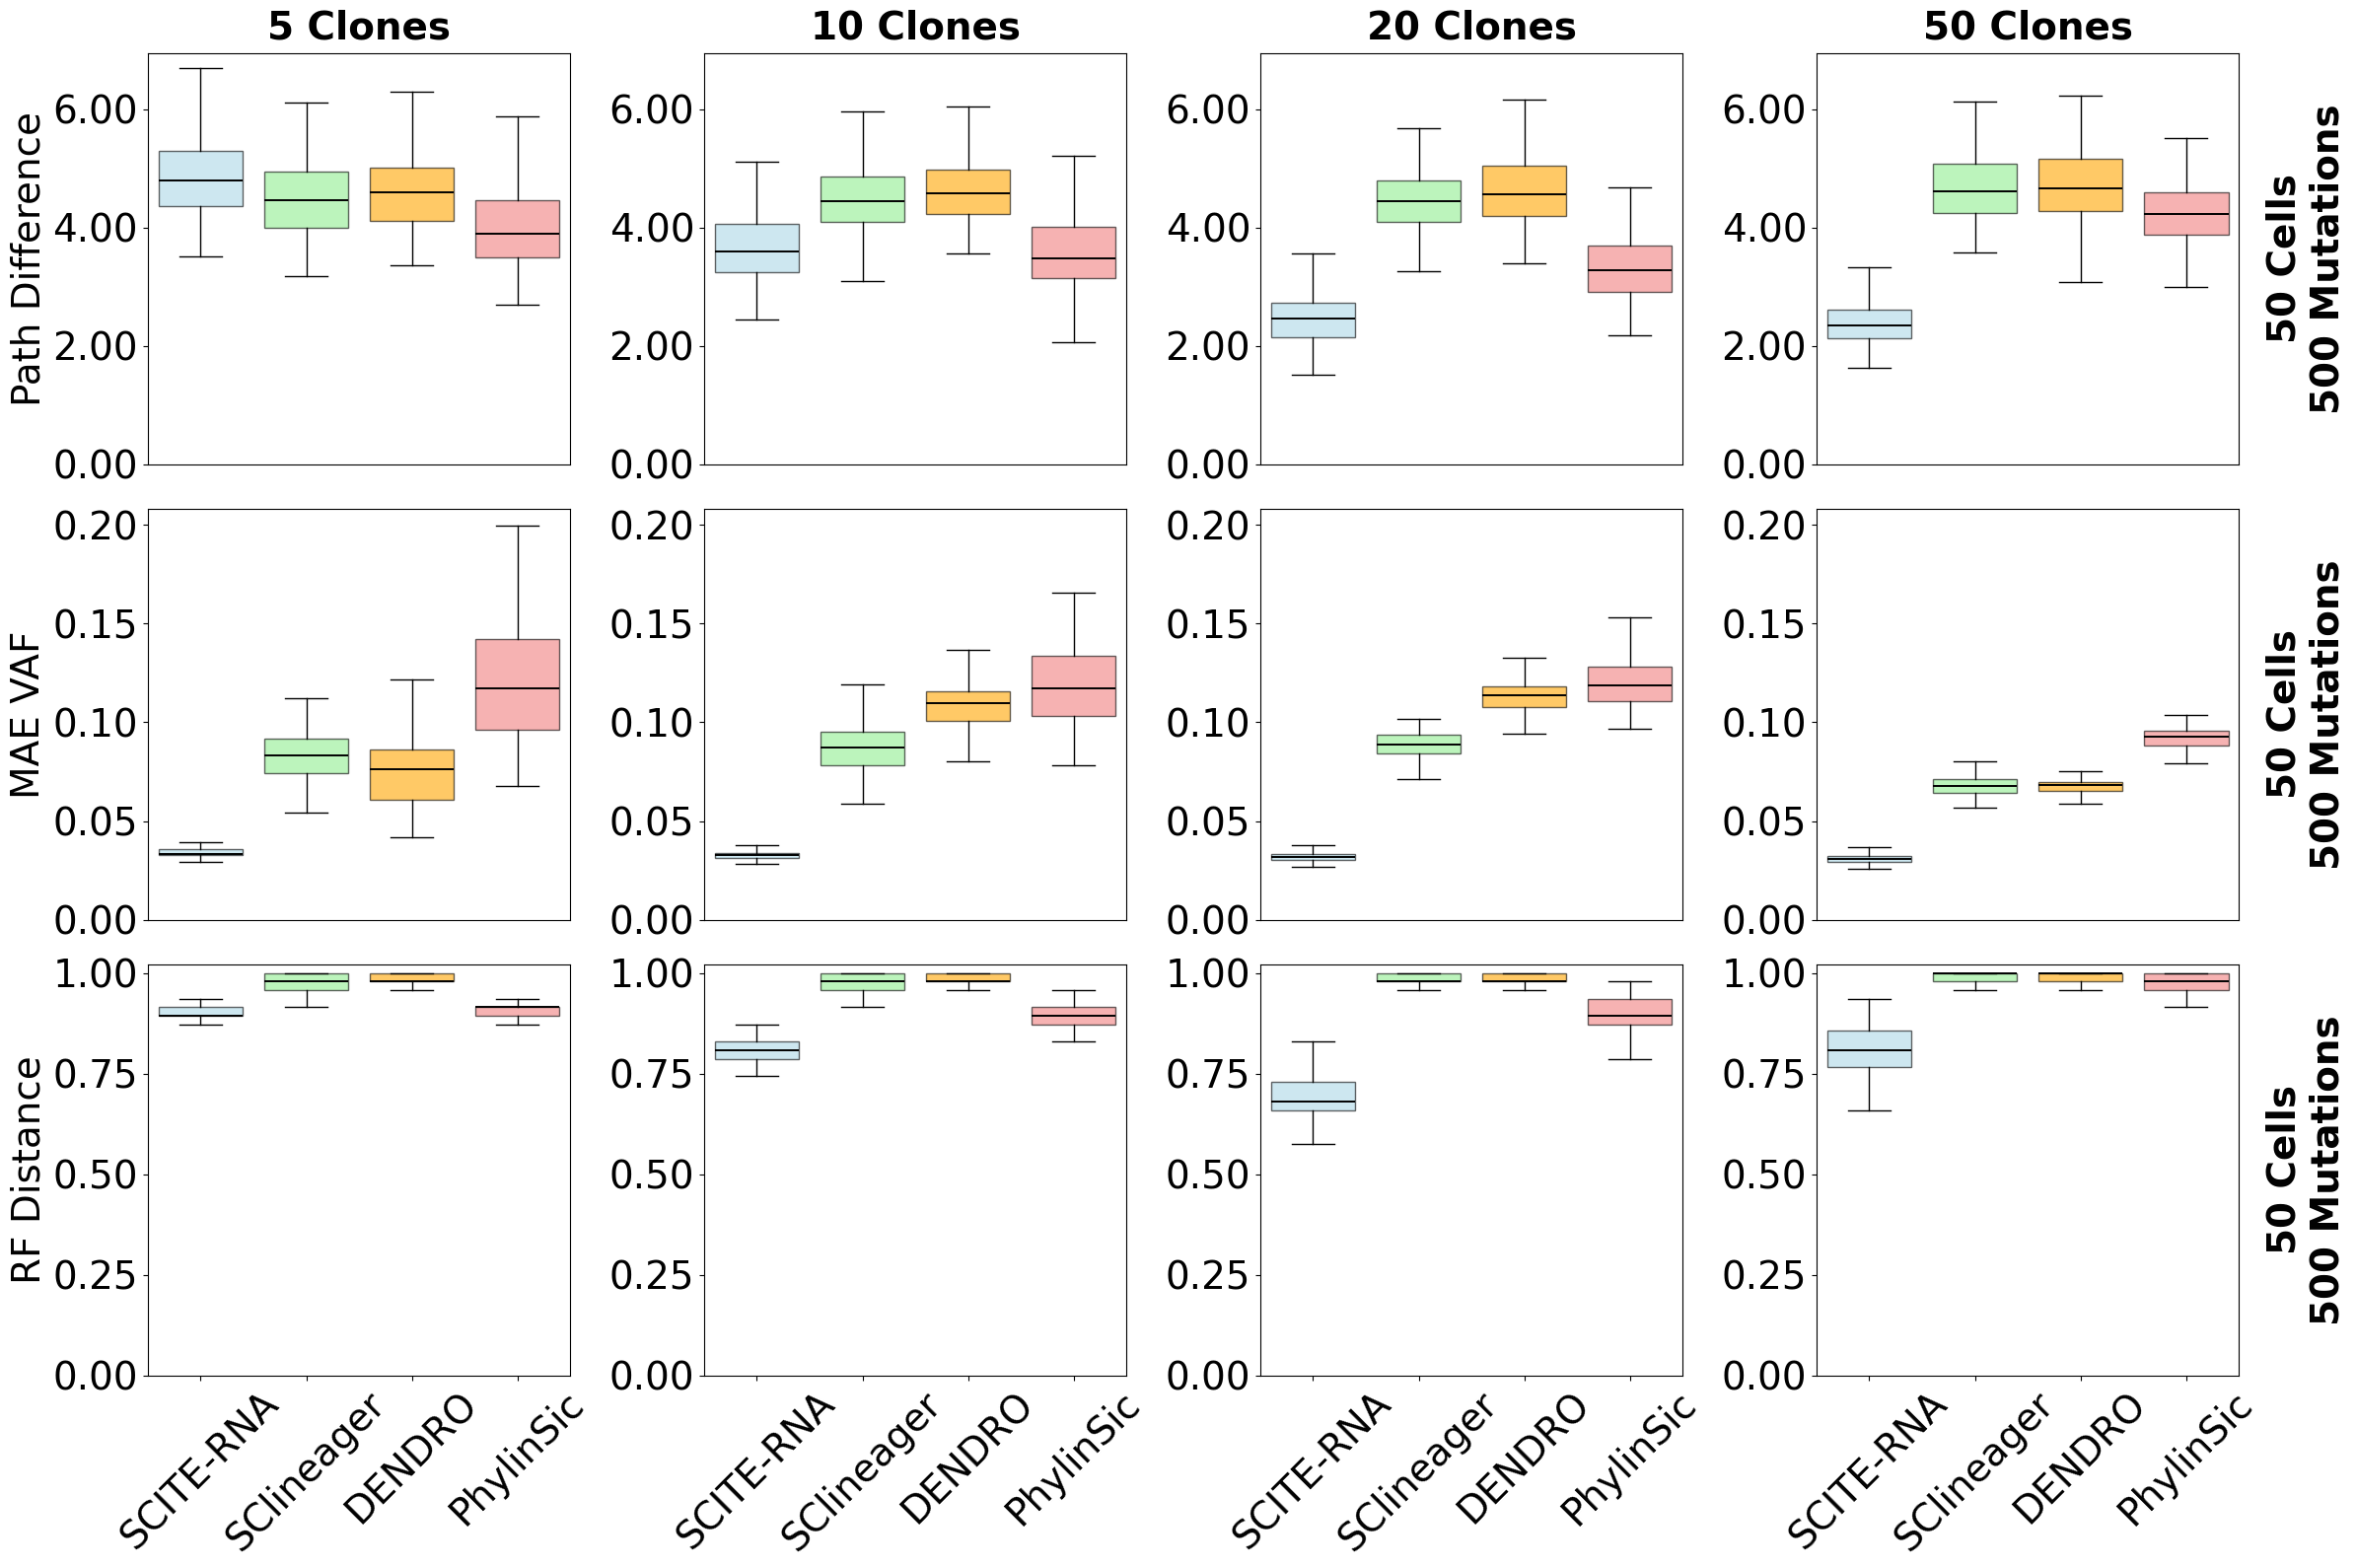

In [9]:
def plot_combined(data_list, clones, models=["SCITE-RNA", "SClineager", "DENDRO", "PhylinSic"]):

    n_c, n_m = 50, 500  # fixed cell and mutation counts
    rows = len(data_list)
    cols = len(clones)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows + 1), sharey=False)
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    colors = ["lightblue", "lightgreen", "orange", "lightcoral"]
    alpha_value = 0.6

    title_size = 28
    label_size = 28
    tick_size = 28
    box_width = 1.4
    boxplot_widths = 0.8

    plot_titles = ["Path Difference", "MAE VAF", "RF Distance"]

    for row_idx, (data, plot_title) in enumerate(zip(data_list, plot_titles)):
        row_whiskers = []

        for col_idx, clone in enumerate(clones):
            sample_key = f"{n_c}_{n_m}"
            all_samples = [data[model][sample_key][clone] for model in models]

            if plot_title == "RF Distance":
                all_samples = np.array(all_samples).T/(2*(n_c-3))

            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            if row_idx == 0:
                if clone == "":
                    ax.set_title("50 Clones", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == rows - 1:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(plot_title, fontsize=label_size)
            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        # Apply uniform y-limits across each row
        combined = np.concatenate(row_whiskers)
        ymin, ymax = combined.min(), combined.max()
        yrange = ymax - ymin
        ymin = 0
        ymax += 0.05 * yrange

        if np.isfinite(ymin):
            for col_idx in range(cols):
                axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig("../data/results/figures/Figure_Path_VAF_RF.pdf")
    plt.show()

plot_combined([path_len_differences, genotype_differences, rf_differences], ["5", "10", "20", ""])

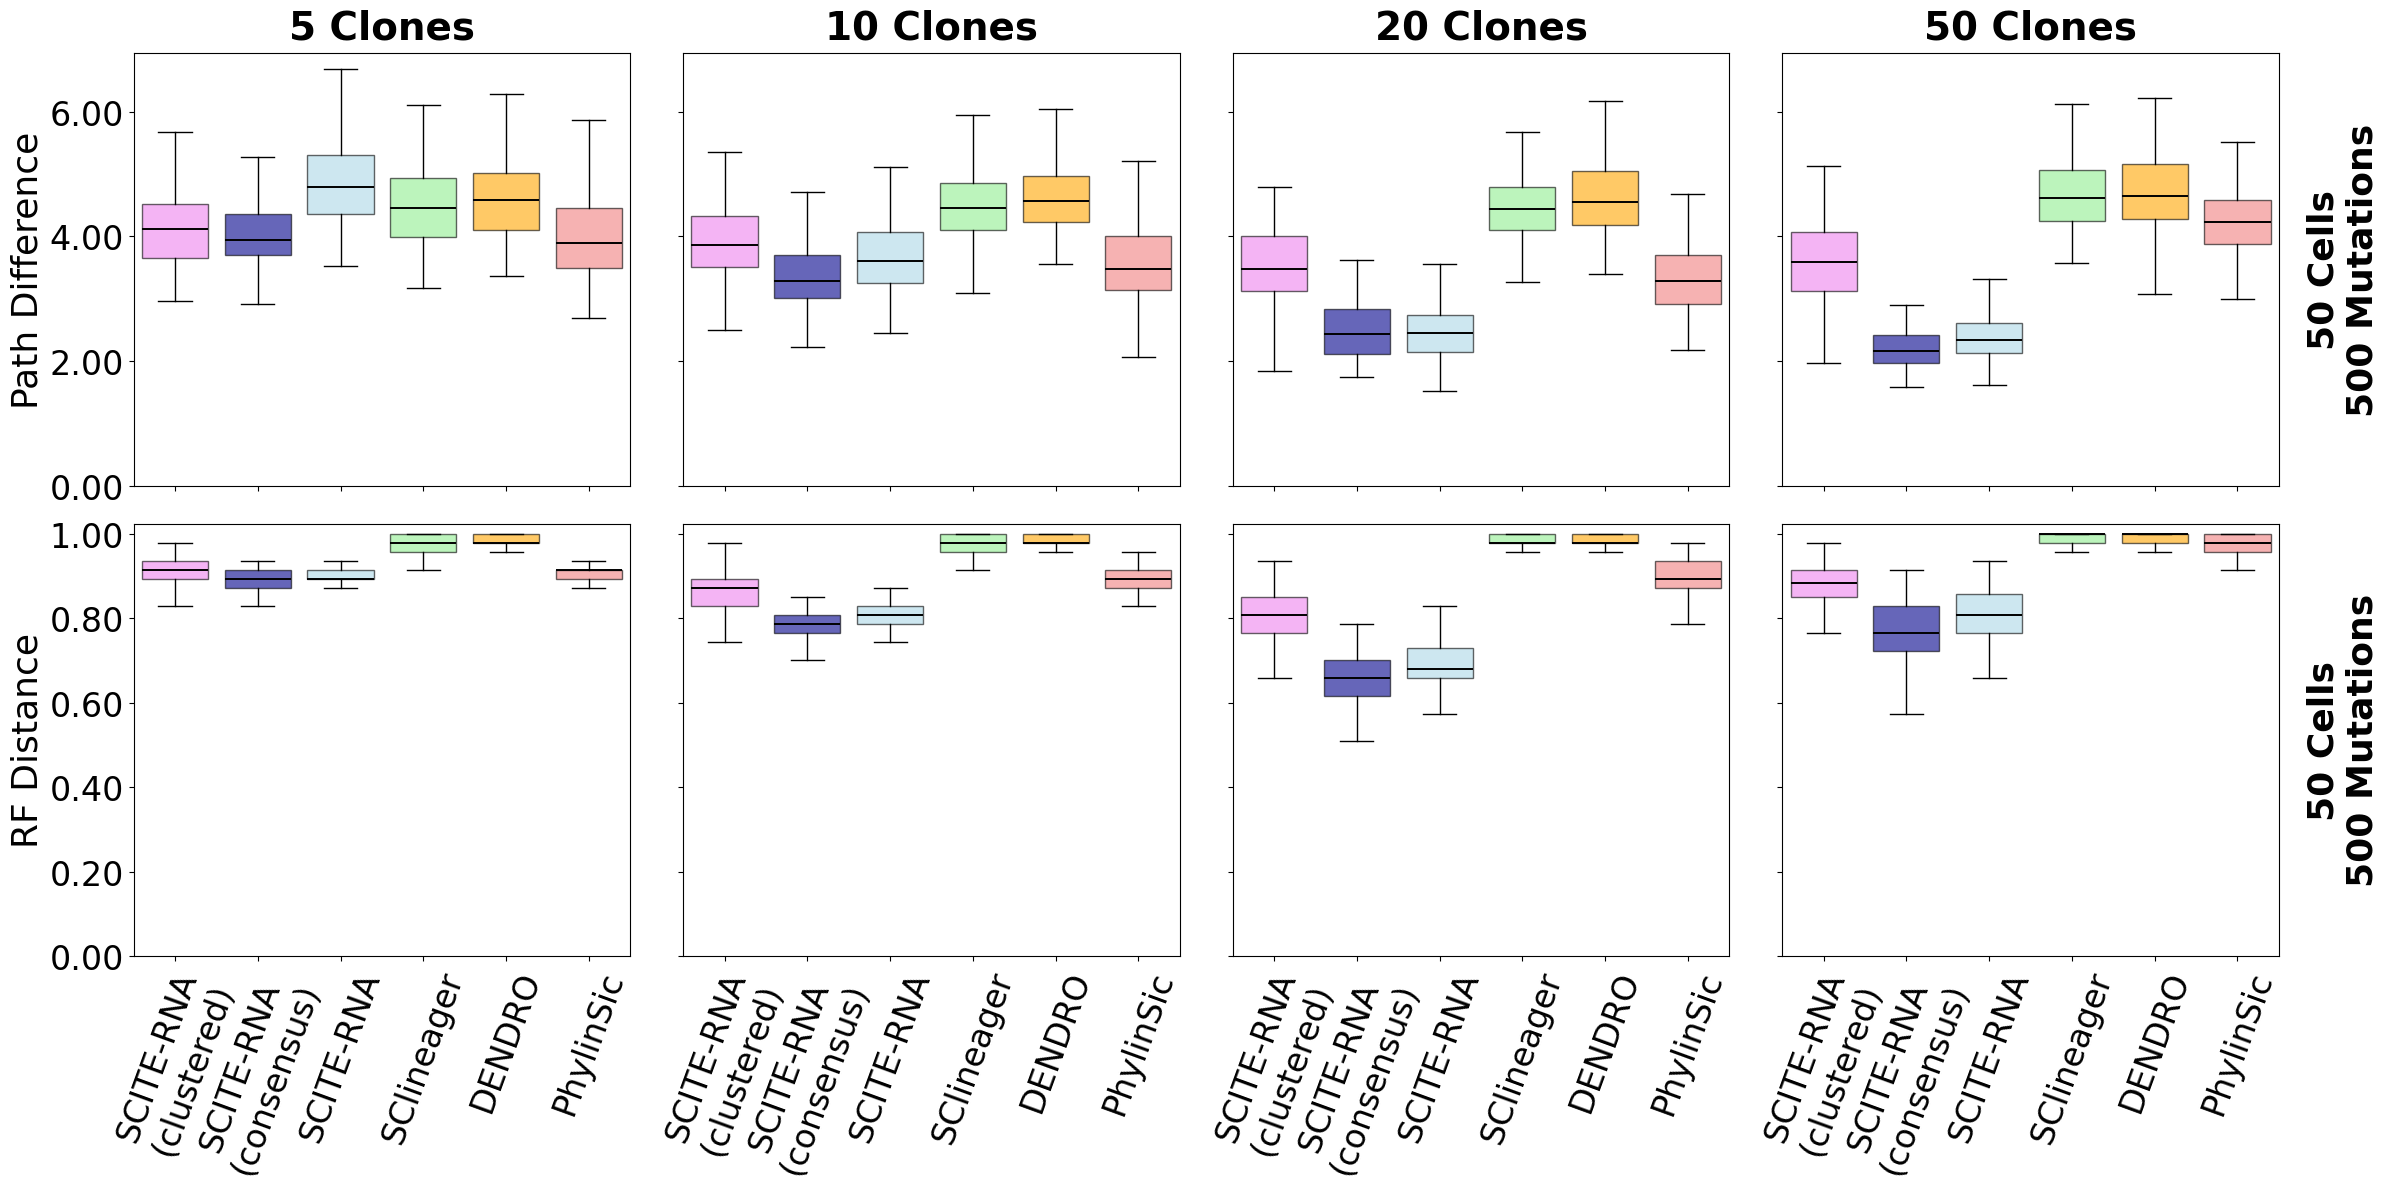

In [12]:
def plot_combined(datasets, clones, models=["SCITE-RNA-clustered", "SCITE-RNA-consensus", "SCITE-RNA", "SClineager", "DENDRO", "PhylinSic"]):
    n_c, n_m = 50, 500
    n_datasets = len(datasets)
    cols = len(clones)
    fig, axes = plt.subplots(n_datasets, cols, figsize=(6 * cols, 6 * n_datasets), sharey='row', sharex=True)
    if n_datasets == 1:
        axes = np.expand_dims(axes, axis=0)
    if cols == 1:
        axes = np.expand_dims(axes, axis=1)

    colors = ["violet", "darkblue", "lightblue", "lightgreen", "orange", "lightcoral"]
    alpha_value = 0.6
    title_size = 28
    label_size = 26
    tick_size = 24
    box_width = 1.4
    boxplot_widths = 0.8
    row_whiskers = [[] for _ in range(n_datasets)]

    for dataset_idx, dataset in enumerate(datasets):
        for col_idx, clone in enumerate(clones):
            sample_key = f"{n_c}_{n_m}"
            all_samples = [dataset[model][sample_key][clone] for model in models]

            if dataset_idx == 1:
                all_samples = np.array(all_samples).T/(2*(n_c-3))

            ax = axes[dataset_idx, col_idx]

            # Plot boxplots
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)
            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)
            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers[dataset_idx].append(whisker_data)

            custom_labels = [
                "SCITE-RNA\n(clustered)",
                "SCITE-RNA\n(consensus)",
                "SCITE-RNA",
                "SClineager",
                "DENDRO",
                "PhylinSic"
            ]
            ax.set_xticks(range(1, len(models) + 1))
            ax.set_xticklabels(custom_labels, fontsize=tick_size, rotation=70, ha='center', va='top')

            if dataset_idx == 0:
                if clone == "":
                    ax.set_title("50 Clones", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

            # Add y-axis label only to the first subplot of each row
            if col_idx == 0:
                if dataset_idx == 0:
                    ax.set_ylabel("Path Difference", fontsize=label_size)
                else:
                    ax.set_ylabel("RF Distance", fontsize=label_size)

            # Add cell/mutation info to the last subplot of each row
            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

    # Uniform y-axis limits for each row
    for dataset_idx in range(n_datasets):
        combined = np.concatenate(row_whiskers[dataset_idx])
        ymin, ymax = combined.min(), combined.max()
        yrange = ymax - ymin
        ymin = 0
        ymax += 0.05 * yrange
        for col_idx in range(cols):
            axes[dataset_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig("../data/results/figures/Figure_clustering_consensus_Path_RF.pdf")
    plt.show()

plot_combined([path_len_differences, rf_differences], ["5", "10", "20", ""])

In [ ]:
n_cells = [50, 50, 100, 100, 100, 200, 200, 100, 5000, 1000]
n_mut = [50, 100, 50, 100, 200, 100, 200, 5000, 100, 1000]
path = r"D:\PhD\SCITERNA\simulated_data/"
clone = ""

models = ["SClineager", "SCITE-RNA", "DENDRO", "PhylinSic"]
colors = ["lightgreen", "lightblue", "orange", "lightcoral"]

conditions = []
for n_c, n_m in zip(n_cells, n_mut):
    condition_label = f"{n_c}c\n{n_m}m"
    conditions.append(condition_label)

# if not use_summary_statistics:
runtime_data = {model: [] for model in models}
for n_c, n_m in zip(n_cells, n_mut):
    condition_label = f"{n_c}c {n_m}m"
    base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

    model_runtimes = {model: None for model in models}

    try:
        model_runtimes["SCITE-RNA"] = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_runtimes.txt")).tolist()
    except Exception as e:
        print(f"SCITE-RNA runtime data missing for {condition_label}: {e}")

    try:
        model_runtimes["SClineager"] = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_runtimes.txt")).tolist()
    except Exception as e:
        print(f"SClineager runtime data missing for {condition_label}: {e}")

    try:
        model_runtimes["DENDRO"] = np.loadtxt(os.path.join(base_path, "dendro", "dendro_runtimes.txt")).tolist()
    except Exception as e:
        print(f"DENDRO runtime data missing for {condition_label}: {e}")

    try:
        model_runtimes["PhylinSic"] = np.loadtxt(os.path.join(base_path, "phylinsic", "phylinsic_runtimes.txt")).tolist()
    except Exception as e:
        print(f"PhylinSic runtime data missing for {condition_label}: {e}")

    for model in models:
        if model_runtimes[model] is not None:
            runtime_data[model].append(model_runtimes[model])
        else:
            runtime_data[model].append([])

fig, ax = plt.subplots(figsize=(14, 6))

positions = []
box_data = []
group_spacing = 2
box_width = 1.2

tick_positions = []
tick_labels = []

for idx, condition in enumerate(conditions):
    group_positions = []
    for offset, model in enumerate(models):
        pos = idx * group_spacing # + offset
        positions.append(pos)
        group_positions.append(pos)
        box_data.append(runtime_data[model][idx])

    tick_center = np.mean(group_positions)
    tick_positions.append(tick_center)
    tick_labels.append(condition)

# Plot boxplots
box = ax.boxplot(box_data, positions=positions, widths=box_width, patch_artist=True, showfliers=False, medianprops=dict(linewidth=1.5, color='black'))

for patch, color in zip(box["boxes"], [colors[i % len(models)] for i in range(len(box_data))]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    patch.set_alpha(0.7)

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, ha='center', fontsize=15)
ax.set_ylabel("Runtime (log seconds)", fontsize=16)
ax.set_yscale("log")
ax.tick_params(axis='y', labelsize=12)
ax.grid(False)
ax.set_ylim(1e-2, 5e5)

reference_lines = [0.1, 1, 10, 100, 1000]
for y in reference_lines:
    ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.7)
    ax.text(len(conditions)*group_spacing - 1, y, f'{y}s', va='bottom', ha='right', fontsize=12, color='gray', zorder=1)

legend_patches = [Patch(facecolor=colors[i], edgecolor=colors[i], label=models[i]) for i in range(len(models))]
ax.legend(handles=legend_patches, title="Models", loc='upper left', fontsize=13, title_fontsize=15, facecolor='white', framealpha=1.0, edgecolor='black')

plt.tight_layout()
plt.savefig("../data/results/figures/Figure_model_runtime_comparison.pdf")
plt.show()

In [ ]:
# with open("../data_summary/simulated_data/runtimes.json", "w") as f:
#     json.dump(runtime_data, f)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

n_cells = [50, 50, 100, 100, 100, 200, 200, 100, 1000, 5000]
n_mut = [50, 100, 50, 100, 200, 100, 200, 5000, 1000, 100]
path = r"D:\PhD\SCITERNA\simulated_data/"
clone = ""

models = ["SClineager", "SCITE-RNA", "DENDRO", "PhylinSic"]
colors = ["lightgreen", "lightblue", "orange", "lightcoral"]

conditions = []
for n_c, n_m in zip(n_cells, n_mut):
    condition_label = f"{n_c}c\n{n_m}m"
    conditions.append(condition_label)

# if not use_summary_statistics:
runtime_data = {model: [] for model in models}
for n_c, n_m in zip(n_cells, n_mut):
    condition_label = f"{n_c}c {n_m}m"
    base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

    model_runtimes = {model: None for model in models}

    try:
        model_runtimes["SCITE-RNA"] = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_runtimes.txt")).tolist()
    except Exception as e:
        print(f"SCITE-RNA runtime data missing for {condition_label}: {e}")

    try:
        model_runtimes["SClineager"] = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_runtimes.txt")).tolist()
    except Exception as e:
        print(f"SClineager runtime data missing for {condition_label}: {e}")

    try:
        model_runtimes["DENDRO"] = np.loadtxt(os.path.join(base_path, "dendro", "dendro_runtimes.txt")).tolist()
    except Exception as e:
        print(f"DENDRO runtime data missing for {condition_label}: {e}")

    try:
        model_runtimes["PhylinSic"] = np.loadtxt(os.path.join(base_path, "phylinsic", "phylinsic_runtimes.txt")).tolist()
    except Exception as e:
        print(f"PhylinSic runtime data missing for {condition_label}: {e}")

    for model in models:
        if model_runtimes[model] is not None:
            runtime_data[model].append(model_runtimes[model])
        else:
            runtime_data[model].append([])

fig, ax = plt.subplots(figsize=(14, 6))

positions = []
box_data = []
group_spacing = 2
box_width = 1.2

tick_positions = []
tick_labels = []

for idx, condition in enumerate(conditions):
    group_positions = []
    for offset, model in enumerate(models):
        pos = idx * group_spacing # + offset
        positions.append(pos)
        group_positions.append(pos)
        box_data.append(runtime_data[model][idx])

    tick_center = np.mean(group_positions)
    tick_positions.append(tick_center)
    tick_labels.append(condition)

# --- Normalization: ensure each box_data entry is either [] or a sequence (list/ndarray)
normalized_box_data = []
for d in box_data:
    # keep empty lists as-is
    if d == []:
        normalized_box_data.append([])
    else:
        # If it's a numpy array or list-like, convert to list
        if isinstance(d, (list, tuple, np.ndarray)):
            normalized_box_data.append(list(d))
        # If it's a scalar (float/int), wrap into a list
        elif np.isscalar(d):
            normalized_box_data.append([d])
        else:
            # fallback: try to convert to list, otherwise treat as empty
            try:
                normalized_box_data.append(list(d))
            except Exception:
                normalized_box_data.append([])

# Plot boxplots for entries with length > 1
boxplot_indices = [i for i, d in enumerate(normalized_box_data) if len(d) > 10]
boxplot_positions = [positions[i] for i in boxplot_indices]
boxplot_values = [normalized_box_data[i] for i in boxplot_indices]

if boxplot_values:
    box = ax.boxplot(boxplot_values, positions=boxplot_positions, widths=box_width,
                     patch_artist=True, showfliers=False,
                     medianprops=dict(linewidth=1.5, color='black'))

    # color boxes in the original intended color sequence
    for patch, i in zip(box["boxes"], boxplot_indices):
        color = colors[i % len(models)]
        patch.set_facecolor(color)
        patch.set_edgecolor(color)
        patch.set_alpha(0.7)

# Plot single-value entries as stars in correct color
for i, d in enumerate(normalized_box_data):
    if len(d) <= 10 and len(d) >= 1:
        pos = positions[i]
        y = d[0]
        color = colors[i % len(models)]
        offset = (i % len(models) - 1.5) * 0.1
        ax.plot(pos+offset, y, marker='*', markersize=12, markeredgecolor=color,
                markerfacecolor=color, linestyle='', zorder=10, alpha=0.7)

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, ha='center', fontsize=15)
ax.set_ylabel("Runtime (log seconds)", fontsize=16)
ax.set_yscale("log")
ax.tick_params(axis='y', labelsize=12)
ax.grid(False)
ax.set_ylim(1e-2, 2e6)

reference_lines = [0.1, 1, 10, 100, 1000, 10000, 100000]
for y in reference_lines:
    ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.7)
    ax.text(len(conditions)*group_spacing - 1, y, f'{y}s', va='bottom', ha='right', fontsize=12, color='gray', zorder=1)

legend_patches = [Patch(facecolor=colors[i], edgecolor=colors[i], label=models[i]) for i in range(len(models))]
ax.legend(handles=legend_patches, title="Models", loc='upper left', fontsize=13, title_fontsize=15, facecolor='white', framealpha=1.0, edgecolor='black')

plt.tight_layout()
# plt.savefig("../data/results/figures/Figure_model_runtime_comparison.pdf")
plt.show()